Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.


Описание данных
Признаки

    DateCrawled — дата выгрузки ищ базы
    VehicleType — тип кузова
    RegistrationYear — год регистрации
    Gearbox — коробка передач
    Power — мощность (л. с.)
    Model — модель 
    Kilometer — пробег (км)
    RegistrationMonth — месяц регистрации
    FuelType — топливо
    Brand — марка
    NotRepaired — была машина в ремонте или нет
    DateCreated — дата создания анкеты
    NumberOfPictures — количество фотографий
    PostalCode — почтовый индекс
    LastSeen — дата последней активности

Целевой признак

    Price — цена

# 1. Подготовка данных

In [3]:
import pandas as pd
import sklearn
import numpy as np
import time

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import metrics
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, KFold

from catboost import CatBoostRegressor, cv, Pool
import catboost as cat

from lightgbm import LGBMRegressor
import lightgbm as lgb

import xgboost as xgb
from xgboost import XGBRegressor

In [75]:
autos = pd.read_csv('/datasets/autos.csv')

In [76]:
autos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


354369 строк, 15 признаков и 1 целевой признак

9 признаков - категориальные

7 признаков - количественные

Есть пропуски в VehicleType, Gearbox, Power, Model, FuelType, NotRepaired

In [77]:
autos.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [78]:
#посмотрим пропуски подробнее
autos.isna().mean()

DateCrawled          0.000000
Price                0.000000
VehicleType          0.105794
RegistrationYear     0.000000
Gearbox              0.055967
Power                0.000000
Model                0.055606
Kilometer            0.000000
RegistrationMonth    0.000000
FuelType             0.092827
Brand                0.000000
NotRepaired          0.200791
DateCreated          0.000000
NumberOfPictures     0.000000
PostalCode           0.000000
LastSeen             0.000000
dtype: float64

In [79]:
#Заполним пропуски в признаке notrepaired
autos['NotRepaired'] = autos['NotRepaired'].fillna('no')

In [80]:
#для заполнения пропусков в других признаках будем использовать функцию заполнения наиболее частыми значениями с группировкой по другим признакам
def fill_NaN(data, attribute1, attribute2, column):
    data[column] = data.groupby([attribute1, attribute2])[column].transform(lambda x: x.fillna((x.mode()[0] if not x.mode().empty else "unknown")))

In [81]:
#Заполним пропуски в признаке model с группировкой по марке и году выпуска, а после этого заполним пропуски в признаках fueltype, vehicletype, gearbox максимально частыми значениями с группировкой по марке и моделе
fill_NaN(autos, 'Brand', 'RegistrationYear', 'Model')
fill_NaN(autos, 'Brand', 'Model', 'FuelType')
fill_NaN(autos, 'Brand', 'Model', 'VehicleType')
fill_NaN(autos, 'Brand', 'Model', 'Gearbox')

In [82]:
#Проверим сколько у нас получилось объектов со значением признака model = unknown
autos['Model'][autos['Model'] == 'unknown'].count()/autos.shape[0]

0.009713039233115764

In [83]:
#Так как таких объектов меньше 1%, то удалим их из выборки
autos = autos[autos['Model'] != 'unknown'].reset_index(drop = True)

In [84]:
autos.isna().mean()

DateCrawled          0.0
Price                0.0
VehicleType          0.0
RegistrationYear     0.0
Gearbox              0.0
Power                0.0
Model                0.0
Kilometer            0.0
RegistrationMonth    0.0
FuelType             0.0
Brand                0.0
NotRepaired          0.0
DateCreated          0.0
NumberOfPictures     0.0
PostalCode           0.0
LastSeen             0.0
dtype: float64

Рассмотрим признаки, которые не пригодятся для обучения моделей, т.к. не влияют на цену:
    DateCrawled - дата скачивания анкеты из базы
    PostalCode - почтовый индекс владельца анкеты (пользователя)
    LastSeen - дата последней активности пользователя
    DateCreated -дата создания анкеты

In [85]:
#удалим столбцы, которые не пригодятся для обучения
autos = autos.drop(['DateCrawled','PostalCode','LastSeen','DateCreated'], axis=1)

In [86]:
autos['NumberOfPictures'][autos['NumberOfPictures'] == 0].count()

350927

In [87]:
#Столбец NumberOfPictures (количество фотографий автомобиля) заполнен нулями удалим и его
autos = autos.drop('NumberOfPictures', axis=1)

In [88]:
autos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350927 entries, 0 to 350926
Data columns (total 11 columns):
Price                350927 non-null int64
VehicleType          350927 non-null object
RegistrationYear     350927 non-null int64
Gearbox              350927 non-null object
Power                350927 non-null int64
Model                350927 non-null object
Kilometer            350927 non-null int64
RegistrationMonth    350927 non-null int64
FuelType             350927 non-null object
Brand                350927 non-null object
NotRepaired          350927 non-null object
dtypes: int64(5), object(6)
memory usage: 29.5+ MB


In [89]:
#функция для построения графиков
def draw(data, col):
    Q1 = np.quantile(data[col], 0.25, interpolation='midpoint')
    Q3 = np.quantile(data[col], 0.75, interpolation='midpoint')
    IQR = Q3 - Q1
    
    plt.figure(figsize=(15,.5))
    sns.boxplot(data[col]).set(xlim = [Q1-3*(Q3-Q1), Q3+3*(Q3-Q1)])
    plt.show()
    
    plt.figure(figsize=(15,3))
    sns.distplot(data[col])
    plt.show()

### RegistrationYear

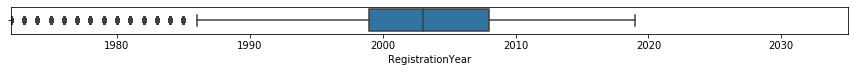

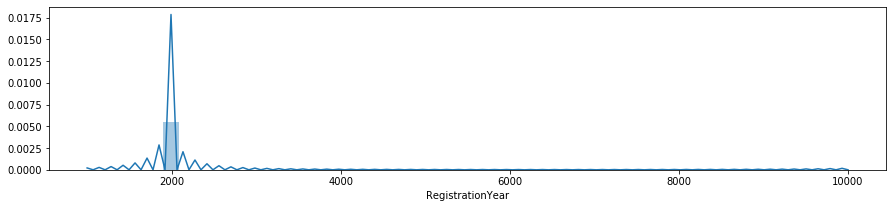

In [90]:
draw(autos, 'RegistrationYear')

Исходя из графика видно, что адекватные значения RegistrationYear находятся в промежутке от 1985 до 2019

In [91]:
autos['RegistrationYear'].describe()

count    350927.000000
mean       2003.938298
std          71.952985
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: RegistrationYear, dtype: float64

In [92]:
#проверим долю значений, которые хотим удалить в Registration Year
1 - len(autos.query('1985 <= RegistrationYear <= 2019'))/len(autos)

0.01331331017562054

In [93]:
#уберем выбросы
autos = autos.query('1985 <= RegistrationYear <= 2019')

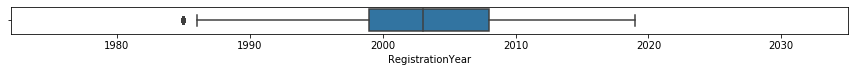

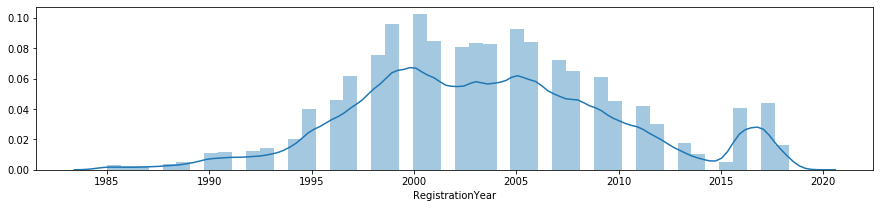

In [94]:
draw(autos, 'RegistrationYear')

### Power

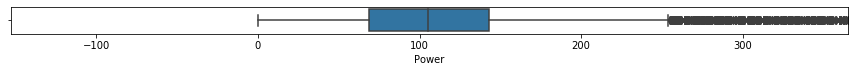

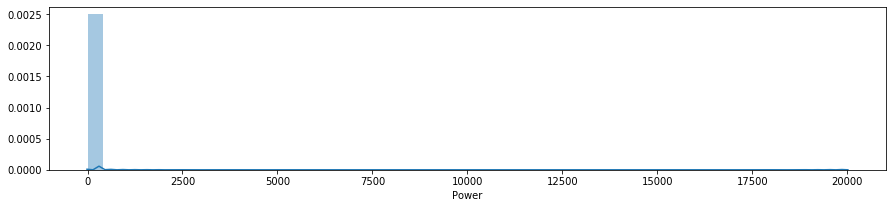

In [95]:
draw(autos, 'Power')

видно, что есть очень большое количество данных, у которых Power = 0

In [96]:
autos['Power'].describe()

count    346255.000000
mean        110.693706
std         187.787285
min           0.000000
25%          69.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: Power, dtype: float64

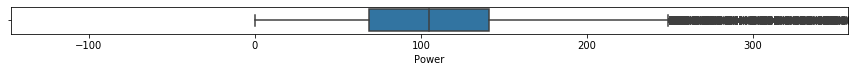

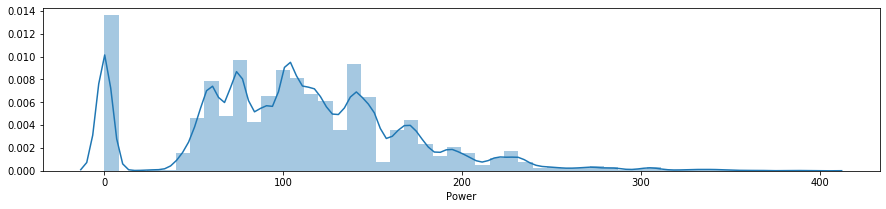

In [97]:
#посмотрим подробнее
draw(autos[autos['Power']<400], 'Power')

объекты с мощностью > 350 практически отсутсвуют

удалим значения мощности выше 350 и заменим нулевые значения на медианные, сгруппированные по модели автомобиля

In [98]:
#Посмотрим на долю значений, которые хотим удалить
1 - len(autos.query('Power <= 350'))/len(autos)

0.0032519386001645945

In [99]:
#уберем значения являющиеся выбросами
autos = autos.query('Power <= 350')

In [100]:
median_Power  = autos.groupby('Model')['Power'].median(skipna = True).to_dict()
def fill_Power (row):
    if row['Power'] == 0:
        return median_Power [row['Model']]
    return row ['Power']
autos['Power'] = autos.apply(lambda row: fill_Power(row), axis = 1)

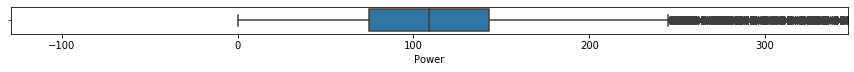

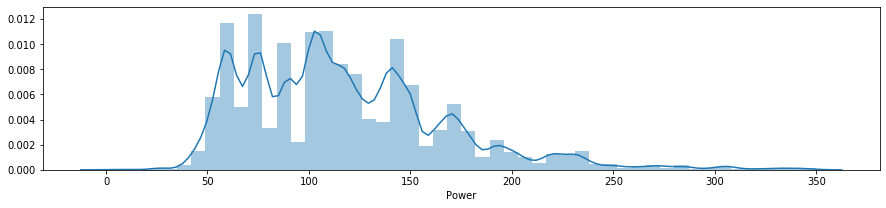

In [101]:
draw(autos, 'Power')

### Kilometer

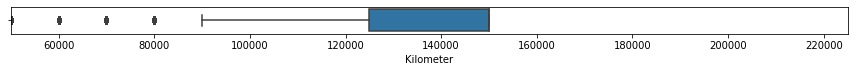

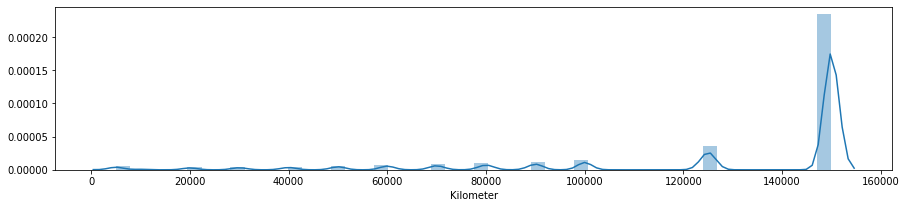

In [102]:
draw(autos, 'Kilometer')

In [103]:
autos['Kilometer'].describe()

count    345129.000000
mean     129030.826155
std       36979.292487
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: Kilometer, dtype: float64

In [104]:
autos['Kilometer'].value_counts()

150000    234323
125000     35712
100000     14088
90000      11214
80000       9692
70000       8237
60000       7158
50000       5943
5000        5208
40000       4701
30000       4183
20000       3692
10000        978
Name: Kilometer, dtype: int64

данные в столбце kilometer, судя по всему, были указаны пользователями путем выбора из списка занчений 

### Price

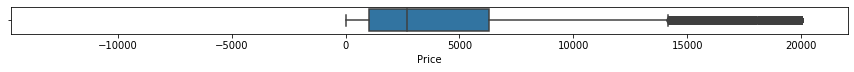

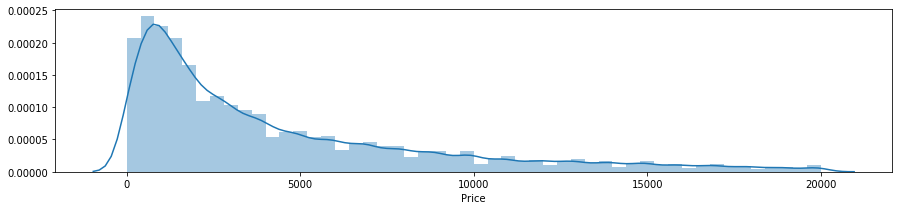

In [105]:
draw(autos, 'Price')

очень большое количество значений находится около нуля


In [106]:
autos['Price'].describe()

count    345129.000000
mean       4375.439833
std        4471.458987
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6300.000000
max       20000.000000
Name: Price, dtype: float64

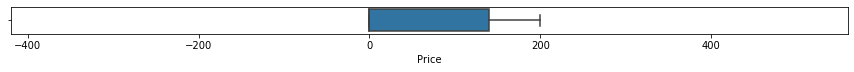

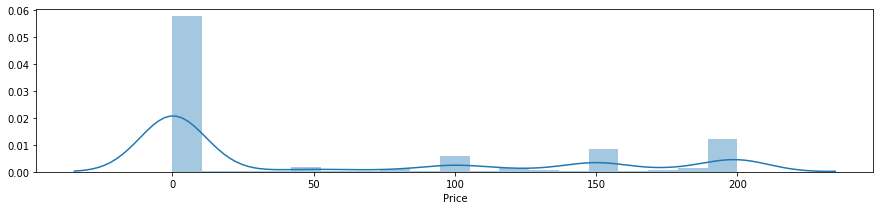

In [107]:
#посомтрим более детально
draw(autos[autos['Price']< 201], 'Price')

In [108]:
#Посмотрим на долю значений, которые хотим удалить
1 - len(autos.query('Price >= 100'))/len(autos)

0.035024585010242526

In [109]:
#уберем значения являющиеся выбросами
autos = autos.query('Price >= 100')

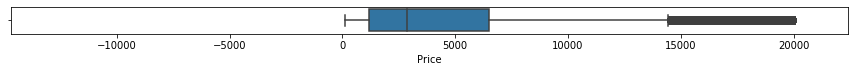

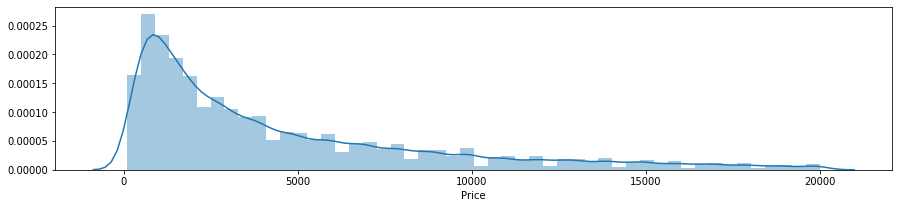

In [110]:
draw(autos, 'Price')

In [111]:
#посмотрим на дубликаты после обработки
autos.duplicated().sum()

32375

In [112]:
#обнаруженные дубли удалим
autos = autos.drop_duplicates()

In [113]:
#категориальные признаки закодируем используя OrdinalEncoder
cat_columns = ['VehicleType', 'Model', 'FuelType', 'Brand', 'Gearbox', 'NotRepaired', 'RegistrationYear', 'Kilometer', 'RegistrationMonth']
#encoder = OrdinalEncoder()
#encoder.fit(autos[cat_columns])
#autos.loc[:, cat_columns] =  encoder.transform(autos[cat_columns])

In [114]:
autos.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
0,480,sedan,1993,manual,90.0,golf,150000,0,petrol,volkswagen,no
1,18300,coupe,2011,manual,190.0,a4,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163.0,grand,125000,8,gasoline,jeep,no
3,1500,small,2001,manual,75.0,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69.0,fabia,90000,7,gasoline,skoda,no


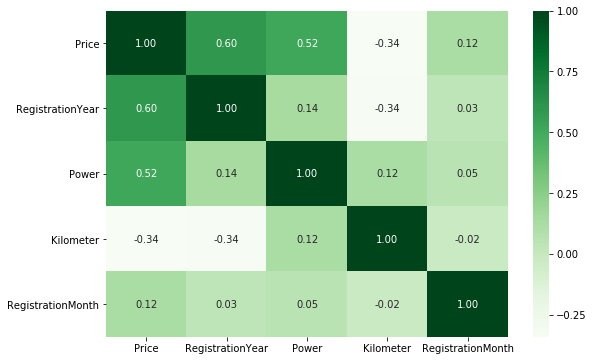

In [115]:
#посмотрим коэф. корреляции методом Спирмена
plt.figure(figsize=(9,6))
sns.heatmap(autos.corr(method='spearman'), annot=True, cmap="Greens", fmt='.2f')

наблюдается зависимость у Price от RegistrationYear и Power

присутствует естественная зависимость между Brand и Model

In [116]:
autos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 300666 entries, 0 to 350926
Data columns (total 11 columns):
Price                300666 non-null int64
VehicleType          300666 non-null object
RegistrationYear     300666 non-null int64
Gearbox              300666 non-null object
Power                300666 non-null float64
Model                300666 non-null object
Kilometer            300666 non-null int64
RegistrationMonth    300666 non-null int64
FuelType             300666 non-null object
Brand                300666 non-null object
NotRepaired          300666 non-null object
dtypes: float64(1), int64(4), object(6)
memory usage: 27.5+ MB


### Выводы:
Исходные данные: 
    354369 строк, 15 признаков и 1 целевой признак;
    9 признаков - категориальные;
    7 признаков - количественные;
    
Были пропуски в VehicleType, Gearbox, Power, Model, FuelType, NotRepaired, которые обработаны с помощью функции заполнения наиболее частыми значениями с группировкой по другим признакам.

Удалены столбцы, которые не пригодятся для обучения: DateCrawled, PostalCode, LastSeen, DateCreated, NumberOfPictures.

Проведен анализ признаков и удалены выбросы.

Данные в столбце kilometer, судя по всему, были указаны пользователями путем выбора из списка занчений.

Данные в столбце NumberOfPictures заполенены нулями, скорее всего какая-то ошибка.

Наибольшая зависимость у целевого признака Price наблюдается от RegistrationYear и Power. Присутствует естественная зависимость между Brand и Model

Удалены дубликаты.

Категориальные признаки закодированы с помощью OrdinalEncoder.

# 2. Обучение моделей

In [117]:
res=[]

In [118]:
target = autos['Price']
features = autos.drop(['Price'], axis=1)
features_train, features_valid, target_train, target_valid = train_test_split(features, target, random_state=42, test_size=0.3)

In [119]:
#Разделим выборку
train_autos, test_autos = train_test_split(autos, test_size = 0.3, random_state = 42)

In [120]:
train_autos.shape, test_autos.shape

((210466, 11), (90200, 11))

In [121]:
#features
features_train = train_autos.drop('Price', axis = 1)
features_test = test_autos.drop('Price', axis = 1)

In [122]:
#target
target_train = train_autos['Price']
target_test = test_autos['Price']

In [123]:
numeric = ['Power']#features_train.columns

In [124]:
scaler = StandardScaler()

In [125]:
scaler.fit(features_train[numeric])

StandardScaler(copy=True, with_mean=True, with_std=True)

In [126]:
features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

### CatBoost

In [127]:
train_dataset = Pool(features_train, target_train, cat_features = cat_columns)
test_dataset = Pool(features_test, target_test, cat_features = cat_columns)

In [128]:
CatBoost_gridsearchcv = CatBoostRegressor()
param_grid = {'n_estimators' : [50, 100], 'max_depth' : [5, 7, 10], 'verbose' : [0], 'random_state' : [42]}
CV = GridSearchCV(estimator = CatBoost_gridsearchcv, param_grid = param_grid, cv = 2, scoring = 'neg_mean_squared_error')
CV.fit(features_train, target_train, cat_features = cat_columns)

GridSearchCV(cv=2, error_score='raise-deprecating',
             estimator=<catboost.core.CatBoostRegressor object at 0x7f6a1f219c10>,
             iid='warn', n_jobs=None,
             param_grid={'max_depth': [5, 7, 10], 'n_estimators': [50, 100],
                         'random_state': [42], 'verbose': [0]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [129]:
CV.best_params_

{'max_depth': 10, 'n_estimators': 100, 'random_state': 42, 'verbose': 0}

In [130]:
model_CatBoost = CatBoostRegressor(loss_function = 'RMSE', n_estimators = 100, max_depth = 10, random_state = 42, verbose = 0)

In [133]:
start = time.time()

#model_CatBoost.fit(train_dataset, eval_set = test_dataset, plot = True)
model_CatBoost.fit(features_train, target_train, plot = True, cat_features = cat_columns)

training_time = time.time() - start

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [134]:
start = time.time()
model_CatBoost.predict(features_test)
predict_time = time.time() - start

In [135]:
params = {'loss_function' : 'RMSE', 'max_depth': 10, 'n_estimators': 100, 'random_state': 42, 'verbose': 0}
cv_data = cv(params = params, pool = train_dataset, fold_count = 5, shuffle = True, plot = True, verbose = False)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

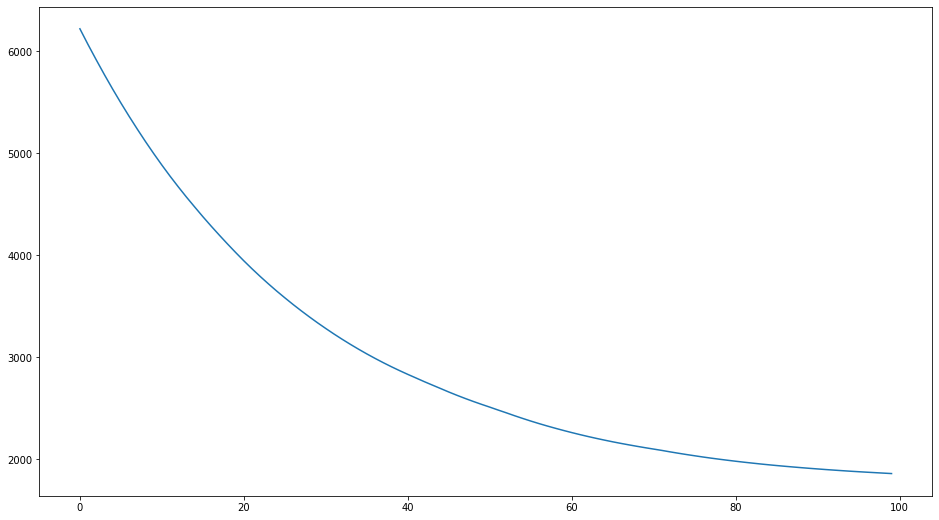

In [136]:
plt.figure(figsize=(16,9))
plt.plot(cv_data['test-RMSE-mean'])

In [137]:
res.append([training_time, predict_time, pd.Series(cv_data['test-RMSE-mean']).min()])

,Feature Id,Importances
0,RegistrationYear,38.179027
1,Power,27.300776
2,Brand,11.417705
3,Kilometer,7.690223
4,VehicleType,7.161248
5,NotRepaired,3.281436
6,FuelType,2.972414
7,Model,1.287795
8,Gearbox,0.480077
9,RegistrationMonth,0.229300


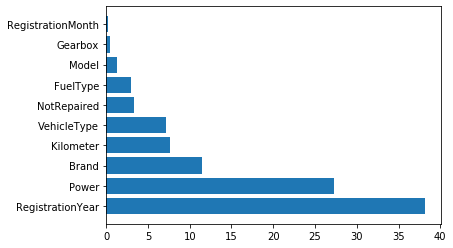

In [138]:
plt.figure() 
feature_import = model_CatBoost.get_feature_importance(train_dataset, prettified = True) 
plt.barh(feature_import['Feature Id'],feature_import['Importances'])
feature_import

Важные признаки CatBoost:

    RegistrationYear
    Power
    Brand
    Kilometer        
    VehicleType
    
    NotRepaired
    FuelType
    Model
    Gearbox
    RegistrationMonth

### LightGBM

In [141]:
features_train[cat_columns] = features_train[cat_columns].astype('category')
features_test[cat_columns] = features_test[cat_columns].astype('category')

In [142]:
autos_trainLGB = lgb.Dataset(data = features_train, label = target_train, categorical_feature=cat_columns)
autos_testLGB = lgb.Dataset(data = features_test, label = target_test, categorical_feature=cat_columns)

In [143]:
LightGBM_gridsearchcv = LGBMRegressor()
param_grid = {'boosting_type' : ['gbdt'], 'n_estimators' : [50, 100], 'max_depth' : [5, 7, 10], 'verbose' : [0], 'random_state' : [42]}
CV = GridSearchCV(estimator = LightGBM_gridsearchcv, param_grid = param_grid, cv = 2, scoring = 'neg_mean_squared_error')
CV.fit(features_train, target_train, categorical_feature = cat_columns)

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Brand', 'FuelType', 'Gearbox', 'Kilometer', 'Model', 'NotRepaired', 'RegistrationMonth', 'RegistrationYear', 'VehicleType']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Brand', 'FuelType', 'Gearbox', 'Kilometer', 'Model', 'NotRepaired', 'RegistrationMonth', 'RegistrationYear', 'VehicleType']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Brand', 'FuelType', 'Gearbox', 'Kilometer', 'Model', 'NotRepaired', 'RegistrationMonth', 'RegistrationYear', 'VehicleType']
  'New categorical_fe

GridSearchCV(cv=2, error_score='raise-deprecating',
             estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None,
                                     colsample_bytree=1.0,
                                     importance_type='split', learning_rate=0.1,
                                     max_depth=-1, min_child_samples=20,
                                     min_child_weight=0.001, min_split_gain=0.0,
                                     n_estimators=100, n_jobs=-1, num_leaves=31,
                                     objective=None, random_state=None,
                                     reg_alpha=0.0, reg_lambda=0.0, silent=True,
                                     subsample=1.0, subsample_for_bin=200000,
                                     subsample_freq=0),
             iid='warn', n_jobs=None,
             param_grid={'boosting_type': ['gbdt'], 'max_depth': [5, 7, 10],
                         'n_estimators': [50, 100], 'random_state': [42],
                   

In [144]:
CV.best_params_

{'boosting_type': 'gbdt',
 'max_depth': 7,
 'n_estimators': 100,
 'random_state': 42,
 'verbose': 0}

In [145]:
model_LightGBM = LGBMRegressor(boosting_type = 'gbdt', max_depth = 7,n_estimators = 100, verbose = 0, random_state = 42)

In [146]:
start = time.time()
model_LightGBM.fit(features_train, target_train, categorical_feature = cat_columns, eval_set = (features_test,target_test), eval_metric = 'RMSE', verbose = 0)
training_time = time.time() - start

In [147]:
start = time.time()
model_LightGBM.predict(features_test)
predict_time = time.time() - start

In [148]:
params_LightGBM = {'metrics' : 'RMSE', 'n_estimators' : 100, 'depth' : 10, 'verbose' : 0}
cv_result = lgb.cv(params_LightGBM, autos_trainLGB, nfold = 5)

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


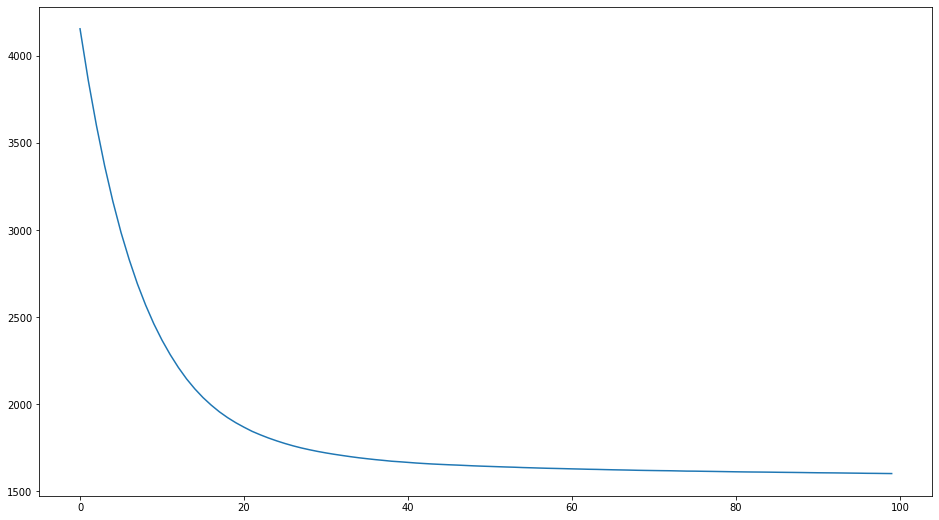

In [149]:
plt.figure(figsize=(16,9))
plt.plot(cv_result['rmse-mean'])

In [150]:
res.append([training_time, predict_time, pd.Series(cv_result['rmse-mean']).min()])

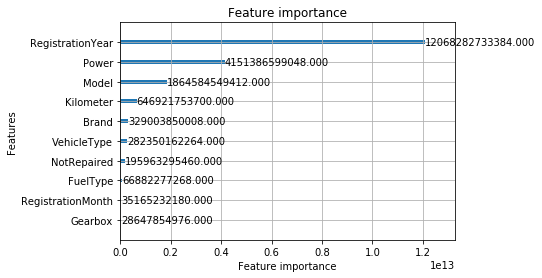

In [151]:
lgb.plot_importance(model_LightGBM, importance_type = 'gain')

Важные признаки LightGBM:

    RegistrationYear
    Power
    Model
    Kilometer
    Brand    
        
    VehicleType
    NotRepaired
    FuelType
    RegistrationMonth
    Gearbox

### XGBoost

In [161]:
encoder = OrdinalEncoder()
encoder.fit(autos[cat_columns])
autos.loc[:, cat_columns] =  encoder.transform(autos[cat_columns])

In [164]:
target = autos['Price']
features = autos.drop(['Price'], axis=1)
features_train, features_valid, target_train, target_valid = train_test_split(features, target, random_state=42, test_size=0.3)
train_autos, test_autos = train_test_split(autos, test_size = 0.3, random_state = 42)
features_train = train_autos.drop('Price', axis = 1)
features_test = test_autos.drop('Price', axis = 1)
target_train = train_autos['Price']
target_test = test_autos['Price']

In [165]:
numeric = features_train.columns
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])	

In [166]:
autos_trainXGBoost = xgb.DMatrix(features_train, label = target_train)

/opt/conda/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [167]:
model_XGBoost = XGBRegressor(max_depth = 10, n_estimators = 100, learning_rate = 0.1, random_state = 42)

In [168]:
start = time.time() 
model_XGBoost.fit(features_train, target_train, eval_set = [(features_train, target_train),(features_test, target_test)], eval_metric = 'rmse', verbose = 100)
training_time = time.time() - start

[22:44:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:5803.68	validation_1-rmse:5810.68
[99]	validation_0-rmse:1289.49	validation_1-rmse:1557.63


In [169]:
start = time.time()
model_XGBoost.predict(features_test)
predict_time = time.time() - start

In [170]:
params_XGBoost = {'eval_metric' : 'rmse', 'learning_rate' : 0.1, 'max_depth' : 6}
cv_results = xgb.cv(params_XGBoost, autos_trainXGBoost, nfold = 5, num_boost_round = 1000)

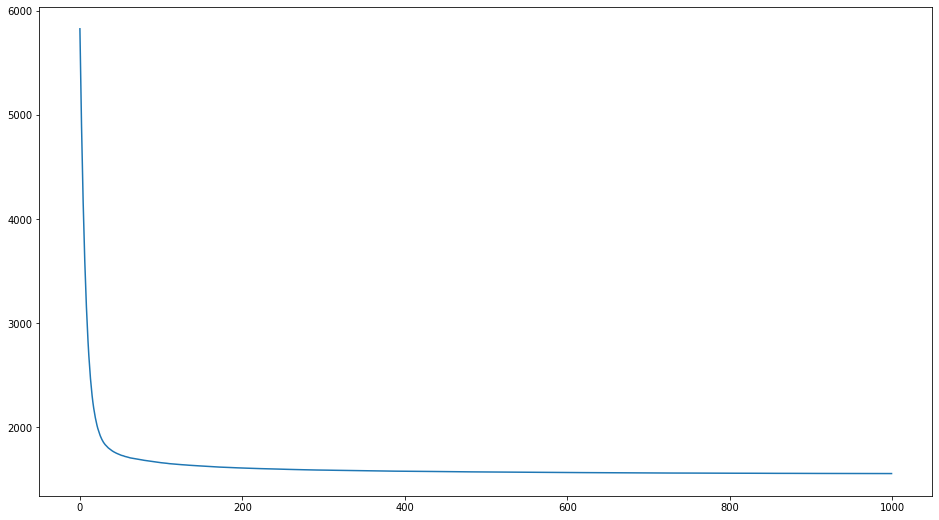

In [171]:
plt.figure(figsize=(16,9))
plt.plot(cv_results['test-rmse-mean'])

In [172]:
res.append([training_time, predict_time, cv_results['test-rmse-mean'].min()])

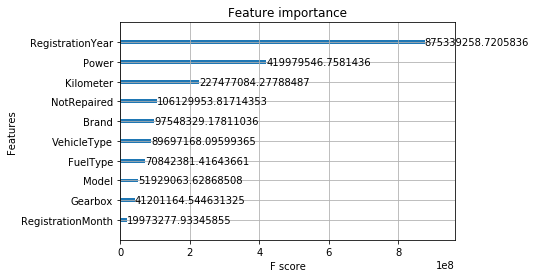

In [173]:
xgb.plot_importance(model_XGBoost, importance_type = 'gain')

Важные признаки XGBoost:

    RegistrationYear
    Power
    Kilometer
    NotRepaired
    Brand
    
    VehicleType    
    FuelType
    Model
    Gearbox
    RegistrationMonth

In [174]:
result = pd.DataFrame(data=res, columns=['training_time', 'predict_time', 'rmse']).rename(index={0: 'CatBoost', 1: 'LightGBM', 2: 'XGBoost'})
display(result)

,training_time,predict_time,rmse
CatBoost,52.083131,0.423378,1860.079678
LightGBM,10.233661,1.304855,1602.243746
XGBoost,53.749341,1.315583,1557.224536


наиболее подходящей моделью с оптимальным качеством и быстродействием оказалась LightGBM

# 3. Анализ моделей

Самым важными признаками для всех моделей оказались: RegistrationYear и Power.

Также важными признаками во всех моделях были Kilometer и Brand.

Признак VehicleType был наиболее важен в CatBoost, признак Model в LightGBM, а признак NotRepaired в тоже время был важен для XGBoost.

Модели показали неплохие результыт RMSE. 

LightGBM показала хороший результат по времени обучния.

LightGBM гораздо быстрее всех обучает.

CatBoost намного быстрее делает предсказания.

Лучшей моделью будет являться LightGBM с оптимальным качеством и быстродействием.